# RSNA2024 LSDC Training Baseline Model

**This notebook outlines the end-to-end process for training and evaluating an image classification model using PyTorch and Albumentations.**

Initially, it defines **data augmentation techniques** to enhance a small dataset by applying transformations such as brightness adjustments, blurring, and distortion, thereby increasing model robustness. 

It then **verifies the data pipeline by testing the DataLoader** to ensure proper image loading and transformation. 

The notebook proceeds to **define a custom image classification model using the timm library**, and tests its functionality with random input. 

Finally, it demonstrates a comprehensive **training loop with K-Fold Cross-Validation and mixed precision training to optimize model performance**, while monitoring and saving the best-performing models based on validation metrics.

In [1]:
!unzip -q /kaggle/input/rsna2024-lsdc-transforming-dicom-into-png/_output_.zip

# Import Libraries

In [2]:
# Import standard libraries
import os                 # Provides functions for interacting with the operating system
import gc                 # Garbage collection for memory management
import sys                # System-specific parameters and functions
from PIL import Image     # Python Imaging Library for image processing
import cv2                # OpenCV for advanced image processing
import math, random       # Mathematical functions and random number generation
import numpy as np        # Numerical operations and array handling
import pandas as pd       # Data manipulation and analysis
from glob import glob     # File pattern matching
from tqdm import tqdm     # Progress bars for loops
import matplotlib.pyplot as plt  # Plotting and visualization
from sklearn.model_selection import KFold  # K-Fold Cross-Validation for model evaluation

from collections import OrderedDict

# Import PyTorch libraries
import torch                     # Core PyTorch library
import torch.nn.functional as F  # Functional interface for neural network operations
from torch import nn             # Neural network module
from torch.utils.data import DataLoader, Dataset  # Data handling utilities
from torch.optim import AdamW    # Adam optimizer with weight decay

# Import timm for model architectures
import timm               # PyTorch Image Models library for pre-trained models
from transformers import get_cosine_schedule_with_warmup  # Learning rate scheduler

# Import Albumentations for image augmentation
import albumentations as A  # Data augmentation library for image processing

# Re-import KFold from sklearn for K-Fold Cross-Validation
from sklearn.model_selection import KFold

In [3]:
rd = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'

# Configuration

In [4]:
NOT_DEBUG = False # True -> run normally, False -> debug mode, with lesser computing cost

OUTPUT_DIR = f'rsna24-results'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = os.cpu_count() 
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 42

IMG_SIZE = [512, 512]
IN_CHANS = 30
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.85

N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 20 if NOT_DEBUG else 2
MODEL_NAME = "tf_efficientnet_b3.ns_jft_in1k" if NOT_DEBUG else "tf_efficientnet_b0.ns_jft_in1k"

GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 3

LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True

In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """
    Set the random seed for various libraries to ensure reproducibility.

    Args:
        seed (int): The seed value to be used for random number generation. Default is 8620.
        deterministic (bool): If True, sets the operation to be deterministic. This can be useful 
                              for reproducibility but may reduce performance. Default is False.
    
    This function sets the random seed for the Python `random` module, NumPy, and PyTorch. 
    It also sets the `PYTHONHASHSEED` environment variable to control hash-based operations 
    within Python. Additionally, it configures PyTorch's behavior regarding deterministic 
    operations and the use of the cuDNN library for GPU acceleration.
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    # Set PyTorch random seed
    torch.manual_seed(seed)
    
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(SEED)

# Read TRAIN.csv & clean

In [7]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


Change the state to Label.

The dataframe contains some Nans, which we will replace with -100 so that We and function can ignore them when calculating the loss and score.

In [8]:
df = df.fillna(-100)

In [9]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

/tmp/ipykernel_24/1901592955.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]

# Dataset

In [11]:
'''
The RSNA24Dataset class is designed to handle a dataset of medical images. 
It loads images from different imaging sequences (like Sagittal T1, Sagittal T2/STIR, and Axial T2) 
associated with a specific study_id, combines them into a single array, and then prepares them for 
use in training or evaluation.
'''
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        """
        Initialize the RSNA24Dataset.

        Args:
            df (pandas.DataFrame): The DataFrame containing the dataset information, such as study IDs and labels.
            phase (str): Indicates the phase of the dataset, either 'train' or 'val'. Default is 'train'.
            transform (albumentations.Compose or None): A transformation pipeline to be applied to the images.
        """
        self.df = df               # Store the DataFrame containing study IDs and labels
        self.transform = transform # Store the transformation pipeline if provided
        self.phase = phase         # Store the phase ('train' or 'val') of the dataset

    def __len__(self):
        """
        Return the total number of samples in the dataset.

        Returns:
            int: The number of samples (rows) in the DataFrame.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieve and process a single sample from the dataset.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing:
                - x (numpy.ndarray): The processed image array with shape (30, 512, 512).
                - label (numpy.ndarray): The corresponding label array.
        """
        # Initialize an empty array to hold the image data for this sample
        x = np.zeros((512, 512, IN_CHANS), dtype=np.uint8)
        
        # Get the row of the DataFrame corresponding to the given index
        t = self.df.iloc[idx]
        
        # Extract the study_id and labels from the DataFrame row
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Load the first 10 images from the Sagittal T1 sequence
        for i in range(0, 10, 1):
            try:
                # Construct the file path for the image
                p = f'./cvt_png/{st_id}/Sagittal T1/{i:03d}.png'
                # Open and convert the image to grayscale ('L' mode)
                img = Image.open(p).convert('L')
                # Convert the image to a numpy array and store it in the array 'x'
                img = np.array(img)
                x[..., i] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Sagittal T1')
                pass
            
        # Load the next 10 images from the Sagittal T2/STIR sequence
        for i in range(0, 10, 1):
            try:
                # Construct the file path for the image
                p = f'./cvt_png/{st_id}/Sagittal T2_STIR/{i:03d}.png'
                # Open and convert the image to grayscale ('L' mode)
                img = Image.open(p).convert('L')
                # Convert the image to a numpy array and store it in the array 'x'
                img = np.array(img)
                x[..., i+10] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass
            
        # Load 10 evenly spaced images from the Axial T2 sequence
        axt2 = glob(f'./cvt_png/{st_id}/Axial T2/*.png') # Get a list of all Axial T2 images
        axt2 = sorted(axt2)                              # Sort the images by filename
    
        # Calculate the step size for selecting 10 images evenly spaced across the sequence
        step = len(axt2) / 10.0
        st = len(axt2)/2.0 - 4.0*step
        end = len(axt2)+0.0001
             
        # Loop through the calculated positions and load the corresponding images    
        for i, j in enumerate(np.arange(st, end, step)):
            try:
                # Get the file path for the image closest to the current position
                p = axt2[max(0, int((j-0.5001).round()))]
                # Open and convert the image to grayscale ('L' mode)
                img = Image.open(p).convert('L')
                # Convert the image to a numpy array and store it in the array 'x'
                img = np.array(img)
                x[..., i+20] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass  
        
        # Ensure that at least one image has been successfully loaded    
        assert np.sum(x)>0
        
        # Apply the transformation pipeline if one is provided
        if self.transform is not None:
            x = self.transform(image=x)['image']
        
        # Transpose the array to match the expected input format for PyTorch (channels first)
        x = x.transpose(2, 0, 1)
                
        return x, label

# Data Augmentation
Data augmentation is important because the number of images used for training is extremely small.
See [this notebook](https://www.kaggle.com/code/haqishen/1st-place-soluiton-code-small-ver) by [Qishen Ha](https://www.kaggle.com/haqishen) for help setting up this augmentation.

In [12]:
import albumentations as A

# Define data augmentation transformations for the training phase
transforms_train = A.Compose([
    # Adjust brightness and contrast with a certain probability
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
    # Apply random gamma correction to adjust image intensity
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    
    # Apply one of the following augmentations with a specified probability
    A.OneOf([
        A.MotionBlur(blur_limit=7, p=0.2),
        A.MedianBlur(blur_limit=5, p=0.1),
        A.GaussianBlur(blur_limit=5, p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),
    ], p=0.5),

    # Apply one of the following distortions with a specified probability
    A.OneOf([
        A.OpticalDistortion(distort_limit=1.5, p=0.3),
        A.GridDistortion(num_steps=5, distort_limit=1.0, p=0.2),
        A.ElasticTransform(alpha=3, sigma=50, alpha_affine=50, p=0.4),
    ], p=0.6),

    # Apply random shift, scale, and rotation with a specified probability
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=20, border_mode=0, p=0.7),
    # Randomly crop and resize the image with a specified scale and aspect ratio
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    # Apply coarse dropout to randomly
    A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),    
    # Normalize the image with the specified mean and standard deviation
    A.Normalize(mean=0.5, std=0.5),
])

# Define data augmentation transformations for the validation phase
transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5),
])

# Conditionally set the transforms for training to the validation transforms if debugging or augmentation is disabled
if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val


/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:180: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


# Trying Data Loader
Checking if the data loader works properly.

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.7214) tensor(0.3981)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


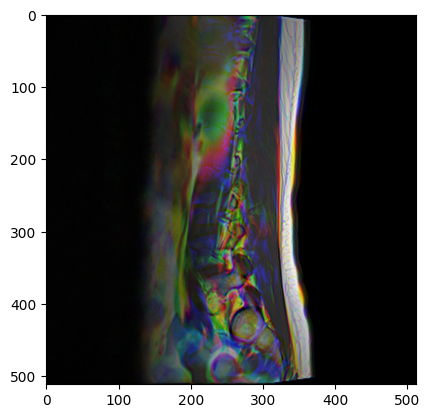

y stat: (512, 512, 3) 0.0 1.0 0.11908135 0.17637749

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.6693) tensor(0.3226)
tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]) torch.Size([1, 25])


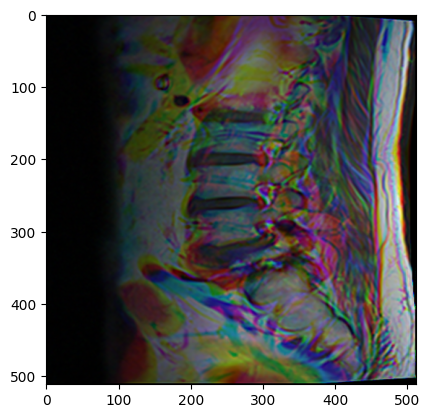

y stat: (512, 512, 3) 0.0 1.0 0.22414117 0.17906277

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.7097) tensor(0.4056)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


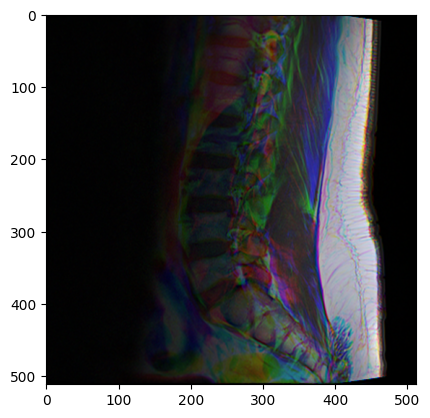

y stat: (512, 512, 3) 0.0 1.0 0.15464914 0.21012934

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.7240) tensor(0.4018)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


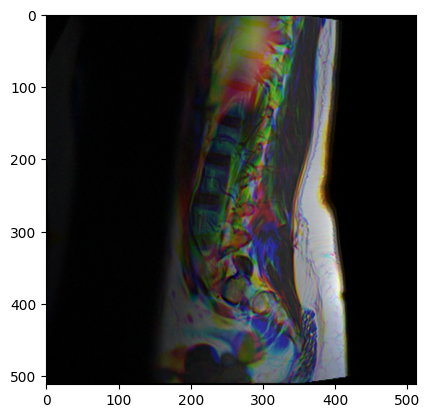

y stat: (512, 512, 3) 0.0 1.0 0.12869923 0.18763523

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.4467) tensor(0.3898)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0]]) torch.Size([1, 25])


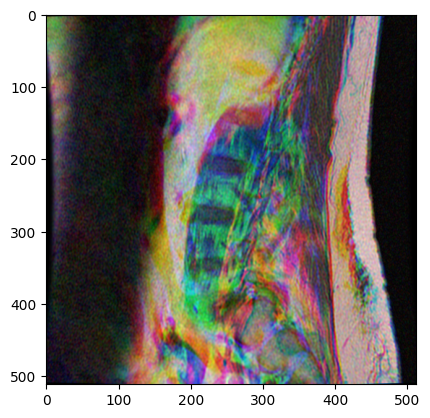

y stat: (512, 512, 3) 0.0 1.0 0.3268126 0.24542229



In [13]:
'''
This code serves as a diagnostic tool to ensure that the RSNA24Dataset and DataLoader are 
properly set up, that the data transformations are applied correctly, and that the data 
can be successfully loaded, processed, and visualized. This helps catch any issues early 
in the data pipeline and ensures that the data augmentation and loading processes are 
working as intended.
'''
# Create a dataset object for the training data, applying the defined transformations
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_train)

# Create a DataLoader to load the dataset in batches
tmp_dl = DataLoader(
            tmp_ds,              # Dataset object
            batch_size=1,        # Number of samples per batch
            shuffle=False,       # Do not shuffle the data
            pin_memory=True,     # Pin memory for faster data transfer to GPU
            drop_last=False,     # Do not drop the last batch if it is smaller than batch_size
            num_workers=0        # Number of subprocesses to use for data loading
            )

# Iterate over the data loader to process a few batches
for i, (x, t) in enumerate(tmp_dl):
    if i==5:break
    print('x stat:', x.shape, x.min(), x.max(),x.mean(), x.std())
    print(t, t.shape)
    
    # Convert the image tensor 'x' to a NumPy array and reorder dimensions to (height, width, channels)
    y = x.numpy().transpose(0,2,3,1)[0,...,:3]
    
    # Normalize the image data from [-1, 1] to [0, 1] for visualization
    y = (y + 1) / 2
    
    # Display the image
    plt.imshow(y)
    plt.show()
    print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()

# Close all Matplotlib figures to release resources
plt.close()

# Clean up by deleting dataset and data loader objects
del tmp_ds, tmp_dl

**Explanation of x stat:**
- x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.8902) tensor(-0.8726) tensor(0.3209)
- tensor([[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
         1]]) torch.Size([1, 25])

**Image Tensor (x):**
- The image tensor has 1 batch, 30 channels, and each image is 512x512 pixels.
- Pixel values have been normalized, with statistics showing minimum, maximum, mean, and standard deviation.

**Label Tensor:**
- The label tensor contains labels for the sample, with values 1 and 2 indicating different categories or classes (classes are 1, 2 and 4).
- Each sample has 25 labels.


# Define Model
We use timm, which is commonly used for image classification.

In [14]:
class RSNA24Model(nn.Module):
    def __init__(self, model_name, in_c=30, n_classes=75, pretrained=True, features_only=False):
        """
        Initialize the RSNA24Model.

        Args:
            model_name (str): The name of the model architecture from timm.
            in_c (int): Number of input channels. Default is 30.
            n_classes (int): Number of output classes. Default is 75.
            pretrained (bool): Whether to use pretrained weights. Default is True.
            features_only (bool): Whether to return features only. Default is False.
        """
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained, 
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )
    
    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Output tensor from the model.
        """
        y = self.model(x)
        return y

# Testing Model
Checking if the model works properly.

In [15]:
# Initialize the model
m = RSNA24Model(MODEL_NAME, in_c=IN_CHANS, n_classes=N_CLASSES, pretrained=False)
# Create a random input tensor
i = torch.randn(2, IN_CHANS, 512, 512)
# Perform a forward pass
out = m(i)
# Print the output shapes, min, and max values
for o in out:
    print(o.shape, o.min(), o.max())

torch.Size([75]) tensor(-1.1293, grad_fn=<MinBackward1>) tensor(0.8736, grad_fn=<MaxBackward1>)
torch.Size([75]) tensor(-0.8969, grad_fn=<MinBackward1>) tensor(0.9570, grad_fn=<MaxBackward1>)


**Output Shape:**
- torch.Size([75]): The model is set up for a classification task with 75 classes, where each output vector corresponds to the class scores or logits for a given input image.

**Output Values:**
- tensor(-0.9389, grad_fn=<MinBackward1>) and tensor(1.1583, grad_fn=<MaxBackward1>) : represent the minimum and maximum values in the output tensor. These values are logits, which can be positive or negative, depending on the activation function used at the final layer.


In [16]:
del m, i, out

# Train loop

In [17]:
'''
This code is designed for training a deep learning model using K-Fold Cross-Validation and 
mixed precision training with PyTorch. 

It starts by configuring Automatic Mixed Precision (AMP) to speed up training and reduce 
memory usage. 

The data is split into training and validation sets using K-Fold Cross-Validation. 

For each fold, it initializes a model and sets up data loaders for both training and validation. 
The training loop employs gradient accumulation, learning rate scheduling, and gradient clipping 
to stabilize training. 

During training, the model's performance is evaluated on a validation set. 
The validation loss and a weighted loss metric are used to track progress, with early stopping 
to prevent overfitting. 

The best-performing model is saved for each fold.
'''
# AMP Configuration:
# Automatically casts operations to mixed precision to speed up training and reduce memory usage.
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # you can use with T4 gpu. or newer
# Helps prevent gradient underflow in mixed precision training.
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

# K-Fold Cross-Validation Setup:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))
    df_train = df.iloc[trn_idx]
    df_valid = df.iloc[val_idx]

    # Training and Validation Data Loaders:
    train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
    train_dl = DataLoader(
                train_ds,
                batch_size=BATCH_SIZE,
                shuffle=True,
                pin_memory=True,
                drop_last=True,
                num_workers=N_WORKERS
                )

    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=BATCH_SIZE*2,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    # Model Initialization and Optimization:
    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
    num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
    num_cycles = 0.475
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                num_warmup_steps=warmup_steps,
                                                num_training_steps=num_total_steps,
                                                num_cycles=num_cycles)

    # Loss Functions:
    weights = torch.tensor([1.0, 2.0, 4.0])
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    criterion2 = nn.CrossEntropyLoss(weight=weights)

    best_loss = 1.2
    best_wll = 1.2
    es_step = 0

    # Training Loop:
    for epoch in range(1, EPOCHS+1):
        print(f'start epoch {epoch}')
        model.train()
        total_loss = 0
        with tqdm(train_dl, leave=True) as pbar:
            optimizer.zero_grad()
            for idx, (x, t) in enumerate(pbar):  
                x = x.to(device)
                t = t.to(device)
                
                with autocast:
                    loss = 0
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col]
                        loss = loss + criterion(pred, gt) / N_LABELS
                        
                    total_loss += loss.item()
                    if GRAD_ACC > 1:
                        loss = loss / GRAD_ACC
    
                if not math.isfinite(loss):
                    print(f"Loss is {loss}, stopping training")
                    sys.exit(1)
    
                pbar.set_postfix(
                    OrderedDict(
                        loss=f'{loss.item()*GRAD_ACC:.6f}',
                        lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                    )
                )
                scaler.scale(loss).backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)
                
                if (idx + 1) % GRAD_ACC == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    if scheduler is not None:
                        scheduler.step()                    
    
        train_loss = total_loss/len(train_dl)
        print(f'train_loss:{train_loss:.6f}')

        total_loss = 0
        y_preds = []
        labels = []
        
        # Validation Loop:
        model.eval()
        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):
                    
                    x = x.to(device)
                    t = t.to(device)
                        
                    with autocast:
                        loss = 0
                        loss_ema = 0
                        y = model(x)
                        for col in range(N_LABELS):
                            pred = y[:,col*3:col*3+3]
                            gt = t[:,col]
 
                            loss = loss + criterion(pred, gt) / N_LABELS
                            y_pred = pred.float()
                            y_preds.append(y_pred.cpu())
                            labels.append(gt.cpu())
                        
                        total_loss += loss.item()   
    
        val_loss = total_loss/len(valid_dl)
        
        y_preds = torch.cat(y_preds, dim=0)
        labels = torch.cat(labels)
        val_wll = criterion2(y_preds, labels)
        
        print(f'val_loss:{val_loss:.6f}, val_wll:{val_wll:.6f}')

        # Early Stopping and Model Saving:
        if val_loss < best_loss or val_wll < best_wll:
            
            es_step = 0

            if device!='cuda:0':
                model.to('cuda:0')                
                
            if val_loss < best_loss:
                print(f'epoch:{epoch}, best loss updated from {best_loss:.6f} to {val_loss:.6f}')
                best_loss = val_loss
                
            if val_wll < best_wll:
                print(f'epoch:{epoch}, best wll_metric updated from {best_wll:.6f} to {val_wll:.6f}')
                best_wll = val_wll
                fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
                torch.save(model.state_dict(), fname)
            
            if device!='cuda:0':
                model.to(device)
            
        else:
            es_step += 1
            if es_step >= EARLY_STOPPING_EPOCH:
                print('early stopping')
                break  
                                

##############################
start fold0
##############################
987 988


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

start epoch 1


 61%|██████    | 37/61 [01:19<00:43,  1.81s/it, loss=0.777864, lr=1.795e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 61/61 [01:54<00:00,  1.88s/it, loss=0.722236, lr=1.265e-04]


train_loss:0.907739


 52%|█████▏    | 16/31 [01:45<00:30,  2.05s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 65%|██████▍   | 20/31 [01:58<00:22,  2.02s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 31/31 [02:34<00:00,  4.99s/it]


val_loss:0.796963, val_wll:0.853558
epoch:1, best loss updated from 1.200000 to 0.796963
epoch:1, best wll_metric updated from 1.200000 to 0.853558
start epoch 2


 13%|█▎        | 8/61 [00:14<00:57,  1.09s/it, loss=0.768798, lr=1.105e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 61/61 [01:42<00:00,  1.68s/it, loss=0.790770, lr=2.225e-06]


train_loss:0.712794


 52%|█████▏    | 16/31 [02:17<00:29,  1.96s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 31/31 [03:03<00:00,  5.90s/it]


val_loss:0.774708, val_wll:0.829840
epoch:2, best loss updated from 0.796963 to 0.774708
epoch:2, best wll_metric updated from 0.853558 to 0.829840
##############################
start fold1
##############################
988 987
start epoch 1


 20%|█▉        | 12/61 [00:18<00:47,  1.04it/s, loss=1.114009, lr=1.667e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 59%|█████▉    | 36/61 [00:52<00:22,  1.11it/s, loss=0.805560, lr=1.827e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 61/61 [01:26<00:00,  1.42s/it, loss=0.774196, lr=1.265e-04]


train_loss:0.952522


 52%|█████▏    | 16/31 [01:45<00:35,  2.37s/it]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 31/31 [02:33<00:00,  4.95s/it]


val_loss:0.788275, val_wll:0.847964
epoch:1, best loss updated from 1.200000 to 0.788275
epoch:1, best wll_metric updated from 1.200000 to 0.847964
start epoch 2


 41%|████      | 25/61 [00:45<01:30,  2.52s/it, loss=0.660223, lr=6.266e-05]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 46%|████▌     | 28/61 [00:46<00:34,  1.06s/it, loss=0.647871, lr=5.768e-05]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 61/61 [01:38<00:00,  1.62s/it, loss=0.917889, lr=2.225e-06]


train_loss:0.743866


 39%|███▊      | 12/31 [02:08<00:45,  2.41s/it]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 31/31 [03:06<00:00,  6.00s/it]

val_loss:0.764208, val_wll:0.822109
epoch:2, best loss updated from 0.788275 to 0.764208
epoch:2, best wll_metric updated from 0.847964 to 0.822109


# 

# Calculation CV

In [18]:
cv = 0
y_preds = []
labels = []
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    df_valid = df.iloc[val_idx]
    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=1,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
    fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
    model.load_state_dict(torch.load(fname))
    model.to(device)   
    
    model.eval()
    with tqdm(valid_dl, leave=True) as pbar:
        with torch.no_grad():
            for idx, (x, t) in enumerate(pbar):
                
                x = x.to(device)
                t = t.to(device)
                    
                with autocast:
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col] 
                        y_pred = pred.float()
                        y_preds.append(y_pred.cpu())
                        labels.append(gt.cpu())

y_preds = torch.cat(y_preds)
labels = torch.cat(labels)

##############################
start fold0
##############################


 63%|██████▎   | 627/988 [00:59<00:29, 12.07it/s]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 70%|██████▉   | 688/988 [01:05<00:29, 10.06it/s]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 70%|██████▉   | 690/988 [01:05<00:26, 11.18it/s]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 988/988 [01:42<00:00,  9.67it/s]


##############################
start fold1
##############################


 56%|█████▌    | 551/987 [00:59<01:00,  7.23it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 987/987 [01:46<00:00,  9.26it/s]


In [19]:
cv = criterion2(y_preds, labels)
print('cv score:', cv.item())

cv score: 0.8259885907173157


# Calculation Competition Metrics
This will give a slightly different score, probably due to the different behavior for nan.

In [20]:
from sklearn.metrics import log_loss
y_pred_np = y_preds.softmax(1).numpy()
labels_np = labels.numpy()
y_pred_nan = np.zeros((y_preds.shape[0], 1))
y_pred2 = np.concatenate([y_pred_nan, y_pred_np],axis=1)
weights = []
for l in labels:
    if l==0: weights.append(1)
    elif l==1: weights.append(2)
    elif l==2: weights.append(4)
    else: weights.append(0)
cv2 = log_loss(labels, y_pred2, normalize=True, sample_weight=weights)
print('cv score:', cv2)

cv score: 0.8259886302334182


In [21]:
np.save(f'{OUTPUT_DIR}/labels.npy', labels_np)
np.save(f'{OUTPUT_DIR}/final_oof.npy', y_pred2)

# Evaluation of random model

In [22]:
random_pred = np.ones((y_preds.shape[0], 3)) / 3.0
y_pred3 = np.concatenate([y_pred_nan, random_pred],axis=1)
cv3 = log_loss(labels, y_pred3, normalize=True, sample_weight=weights)
print('random score:', cv3)

random score: 1.0986122886681102


In [23]:
# !rm -r cvt_png